# Preprocessing

In [1]:
import json
! pip install pandas tensorflow tensorflow_datasets numpy

In [2]:
! pip install imgaug

# Data Preprocessing

In [26]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from keras.src.layers import StringLookup

AUTOTUNE = tf.data.AUTOTUNE

In [73]:
# Relative path to the dataset
iam_lines_path = os.path.join('../../data', 'IAM-data', 'iam_lines_gt.txt')

# Relative path to the images
img_path = os.path.join('../../data', 'IAM-data', 'img')

# Relative path to save the preprocessed data
preprocessed_data_path = os.path.join('../../data', 'preprocessed_data')

# parameters
max_len = 128
padding_token = 99

binarize_threshold = 0.7
image_size = (64, 512)

val_split = 0.2
test_split = 0.2
batch_size = 32

## Create a dataset with the images path and the corresponding labels

In [5]:
def get_dataframe(iam_lines_path: str):
    """
    Extract the image path and the label from the IAM lines file and
    create a pandas dataframe

    Parameters
    ----------
    iam_lines_path : str
        Path to the IAM lines file

    Returns
    -------
    df : pandas dataframe
        Dataframe containing the image path and the label
    """
    data = []
    image_path = None
    label = None

    # in the file, one line contains the image path, the next line the label, then an empty line
    # extract the image path and the label and create a pandas dataframe
    with open(iam_lines_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        line = line.strip()
        if line:
            if not image_path:
                image_path = line
            else:
                label = line
        else:
            if image_path and label:
                data.append((image_path, label))
                image_path = None
                label = None

    df = pd.DataFrame(data, columns=['image_path', 'label'])

    return df


## Resize the images to the same size

In [6]:
def load_images(images_names: list[str]) -> tuple[list[tf.Tensor], tuple[int, int]]:
    """
    Load and decode the images from the specified filepath
    :param images_names: list[str]
        List of images names
    :return: tuple[list[tf.Tensor], tuple[int, int]]
        Images as a tf.Tensor list
        and the maximum height and width of the images
    """
    images = []
    max_h = 0
    max_w = 0

    for image_file in images_names:
        # read the image from the filepath
        file_path = os.path.join(img_path, image_file)
        image = tf.io.read_file(file_path)
        image = tf.image.decode_image(image, channels=1)
        image = tf.cast(image, tf.float32) / 255.0

        # binarize the image
        image = tf.where(image > binarize_threshold, 1, 0)

        # get the maximum height and width
        (h, w) = (image.shape[0], image.shape[1])
        if h > max_h:
            max_h = h
        if w > max_w:
            max_w = w
        images.append(image)

    return images, (max_h, max_w)

In [7]:
def resize_images(images: np.ndarray,
                  size: tuple[int, int] = image_size) -> list[tf.Tensor]:
    """
    Resize the images to the specified shape
    :param size: tuple[int, int]
        Size to resize the images to
        If None, the image is resized to the original size
    :param images: list[tf.Tensor]
        List of images as a tf.Tensor
    :return: list[tf.Tensor]
        Resized images
    """
    # if shape is not specified, use the maximum width and height of the images
    if size is None:
        size = np.max([list(img.shape) for img in images], axis=0)

    (h, w) = (size[0], size[1])

    resized_images = []

    # resize the images
    for img in images:
        resized_img = tf.image.resize_with_pad(img, target_height=h, target_width=w)
        resized_images.append(resized_img)

    return resized_images

## Encode the labels

In [8]:
def get_vocabulary(labels: list[str]) -> tuple[set[str], int]:
    """
    Get the vocabulary from the labels and the maximum label length
    :param labels: list[str]
        List of labels
    :return: tuple[set[str], int]
        Vocabulary and maximum label length
    """

    # get the vocabulary and the max len from the training labels
    vocab = set()
    max_label_len = 0
    for label in labels:
        vocab.update(label)
        if len(label) > max_label_len:
            max_label_len = len(label)

    vocab = sorted(vocab)

    return vocab, max_label_len

In [9]:
def get_encoding(vocab: set[str]) -> tuple[StringLookup, StringLookup]:
    """
    Get the encoding and decoding lookup tables
    :param vocab: set[str]
        Vocabulary
    :return: tuple[tf.lookup.StringLookup, tf.lookup.StringLookup]
        Encoding and decoding lookup tables
    """

    # Mapping characters to integers.
    char_to_num = StringLookup(vocabulary=list(vocab), mask_token=None)

    # Mapping integers back to original characters.
    num_to_char = StringLookup(
        vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
    )

    return char_to_num, num_to_char

In [10]:
def encode_labels(labels: list[str], encoder: StringLookup) -> list[tf.Tensor]:
    """
    Encode the labels and pad them to the same length
    :param labels: list[str]
        List of labels
    :param encoder: tf.lookup.StringLookup
        Encoder
    :return: list[tf.Tensor]
        Encoded and padded labels
    """

    padded_labels = []
    for label in labels:
        encoded_label = encoder(tf.strings.unicode_split(label, input_encoding="UTF-8"))
        length = tf.shape(encoded_label)[0]
        pad_amount = max_label_len - length
        encoded_label = tf.pad(encoded_label, paddings=[[0, pad_amount]], constant_values=padding_token)
        padded_labels.append(encoded_label)

    return padded_labels

## Run the preprocessing

In [11]:
df = get_dataframe(iam_lines_path)
df.head()

# split the dataset into train, validation, test
train_df, test_df = train_test_split(df, test_size=test_split, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=val_split, random_state=42)

In [12]:
train_df.head()

,image_path,label
939,g04-007-05.png,as for more secular purposes. In 1910 Dr. Talbot
187,a03-027-07.png,"some 2,000 delegates, the biggest gathering si..."
4050,b01-053-04.png,to optimism is the sign that Germany and the
4308,e01-062-06.png,to enable the beginner to master all the essen...
1506,c01-014-00.png,"The libretto, by W. H. Auden and Chester Kallman,"


In [13]:
# for each split, load and binarize the images,
# then resize them to the same size

train_imgs, train_shape = load_images(train_df['image_path'].values)
val_imgs, test_shape = load_images(val_df['image_path'].values)
test_imgs, val_shape = load_images(test_df['image_path'].values)

# max_shape = np.max([train_shape, val_shape, test_shape], axis=0)
# print(f"Maximum shape: {max_shape}")

train_imgs = resize_images(train_imgs)
val_imgs = resize_images(val_imgs)
test_imgs = resize_images(test_imgs)

In [14]:
# get the vocabulary and the maximum label length
vocab, max_label_len = get_vocabulary(train_df['label'].values)

max_len = max(max_label_len, max_len)

print(f"Maximum label length: {max_len}")
print(f"Vocabulary: {vocab}")
print(f"Vocabulary size: {len(vocab)}")


Maximum label length: 128
Vocabulary: [' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Vocabulary size: 79


In [15]:
# encode the labels
encoder, decoder = get_encoding(vocab)
encoded_labels = encode_labels(train_df['label'].values, encoder)

In [16]:
# check the encoding
for label in train_df['label'].values[:3]:
    print(label)
    encoded = encoder(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    print(encoded)
    print(tf.strings.reduce_join(decoder(encoded)).numpy().decode("utf-8"))
    print()

as for more secular purposes. In 1910 Dr. Talbot
tf.Tensor(
[54 72  1 59 68 71  1 66 68 71 58  1 72 58 56 74 65 54 71  1 69 74 71 69
 68 72 58 72 13  1 36 67  1 16 24 16 15  1 31 71 13  1 47 54 65 55 68 73], shape=(48,), dtype=int64)
as for more secular purposes. In 1910 Dr. Talbot

some 2,000 delegates, the biggest gathering since 1958
tf.Tensor(
[72 68 66 58  1 17 11 15 15 15  1 57 58 65 58 60 54 73 58 72 11  1 73 61
 58  1 55 62 60 60 58 72 73  1 60 54 73 61 58 71 62 67 60  1 72 62 67 56
 58  1 16 24 20 23], shape=(54,), dtype=int64)
some 2,000 delegates, the biggest gathering since 1958

to optimism is the sign that Germany and the
tf.Tensor(
[73 68  1 68 69 73 62 66 62 72 66  1 62 72  1 73 61 58  1 72 62 60 67  1
 73 61 54 73  1 34 58 71 66 54 67 78  1 54 67 57  1 73 61 58], shape=(44,), dtype=int64)
to optimism is the sign that Germany and the



In [17]:
# create a tf.data.Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_imgs, encoded_labels))
batches = train_data.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
# check the batches
test_batches = batches.take(1).cache()
for batch in test_batches:
    print(batch[0].shape)
    print(batch[1].shape)
    print(batch[1][0])
    print(tf.strings.reduce_join(decoder(batch[1][0])).numpy().decode("utf-8"))

(32, 64, 512, 1)
(32, 75)
tf.Tensor(
[54 72  1 59 68 71  1 66 68 71 58  1 72 58 56 74 65 54 71  1 69 74 71 69
 68 72 58 72 13  1 36 67  1 16 24 16 15  1 31 71 13  1 47 54 65 55 68 73
 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99
 99 99 99], shape=(75,), dtype=int64)
as for more secular purposes. In 1910 Dr. Talbot[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]


2023-06-08 01:41:59.735905: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [44]:
path = preprocessed_data_path
name = "boo"
data = train_data.take(10)

# create dir if it doesn't exist
if not os.path.exists(path):
    os.makedirs(path)

file_path = os.path.join(path, name)
data.save(file_path)

In [57]:
new_data = tf.data.Dataset.load(file_path)


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 18130869029969417120


In [58]:
# show imfo about the dataset
print(data.element_spec)
print(new_data.element_spec)

(TensorSpec(shape=(64, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(75,), dtype=tf.int64, name=None))
(TensorSpec(shape=(64, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(75,), dtype=tf.int64, name=None))


In [61]:
# check if the datasets are equal

# Create an iterator for `data` and `new_data`
data_iter = iter(data)
new_data_iter = iter(new_data)

# Initialize a variable to track the equality of all tensors
all_tensors_equal = True

# Iterate over the datasets and compare each pair of tensors
for data_element, new_data_element in zip(data_iter, new_data_iter):
    # Check if the image tensor and label tensor are equal
    are_equal = tf.equal(data_element[0], new_data_element[0])
    are_equal = tf.reduce_all(are_equal)

    # Update the `all_tensors_equal` variable
    all_tensors_equal = all_tensors_equal and are_equal

    if not all_tensors_equal:
        break

# Print the final result
print("Are all tensors equal?", all_tensors_equal)

Are all tensors equal? tf.Tensor(True, shape=(), dtype=bool)


In [24]:
# load the dataframe
dataset = tf.data.experimental.make_csv_dataset(
    file_path, batch_size=2, label_name="label")
iterator = dataset.as_numpy_iterator()
print(next(iterator))

(OrderedDict([('image', array([b'[[[0.]\n  [0.]\n  [0.]\n  ...\n  [0.]\n  [0.]\n  [0.]]\n\n [[0.]\n  [0.]\n  [0.]\n  ...\n  [0.]\n  [0.]\n  [0.]]\n\n [[0.]\n  [0.]\n  [0.]\n  ...\n  [0.]\n  [0.]\n  [0.]]\n\n ...\n\n [[0.]\n  [0.]\n  [0.]\n  ...\n  [0.]\n  [0.]\n  [0.]]\n\n [[0.]\n  [0.]\n  [0.]\n  ...\n  [0.]\n  [0.]\n  [0.]]\n\n [[0.]\n  [0.]\n  [0.]\n  ...\n  [0.]\n  [0.]\n  [0.]]]',
       b'[[[0.]\n  [0.]\n  [0.]\n  ...\n  [0.]\n  [0.]\n  [0.]]\n\n [[0.]\n  [0.]\n  [0.]\n  ...\n  [0.]\n  [0.]\n  [0.]]\n\n [[0.]\n  [0.]\n  [0.]\n  ...\n  [0.]\n  [0.]\n  [0.]]\n\n ...\n\n [[0.]\n  [0.]\n  [0.]\n  ...\n  [0.]\n  [0.]\n  [0.]]\n\n [[0.]\n  [0.]\n  [0.]\n  ...\n  [0.]\n  [0.]\n  [0.]]\n\n [[0.]\n  [0.]\n  [0.]\n  ...\n  [0.]\n  [0.]\n  [0.]]]'],
      dtype=object))]), array([b'[62 72  1 62 67  1 54  1 69 74 55  1 76 61 58 71 58  1 73 61 58  1 54 74\n 73 61 68 71  1 73 61 71 68 76 72  1 54 99 99 99 99 99 99 99 99 99 99 99\n 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 

In [77]:
decoder_path = os.path.join(preprocessed_data_path, "decoder.txt")
with open(decoder_path, 'w') as f:
    for item in vocab:
        f.write("%s\n" % item)


In [78]:
decoder2 = []
with open(decoder_path, 'r') as f:
    for line in f:
        decoder2.append(line.strip())

2023-06-08 13:38:43.761363: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


IndexError: index 2 is out of bounds for axis 1 with size 2

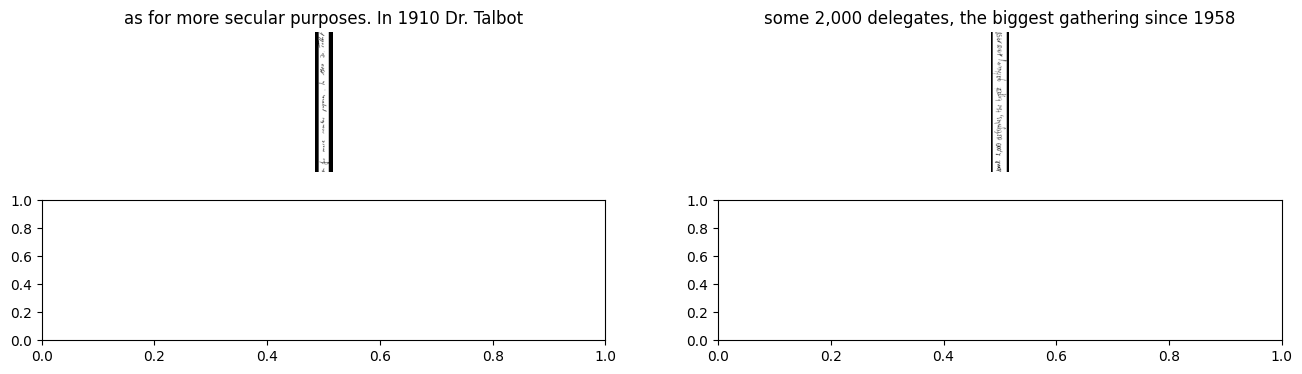

In [79]:
import matplotlib.pyplot as plt

decoder2 = StringLookup(
        vocabulary=decoder.get_vocabulary(), mask_token=None, invert=True
    )

for data in batches.take(1):
    images, labels = data[0], data[1]

    _, ax = plt.subplots(2, 2, figsize=(16, 4))

    for i in range(4):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(
            tf.math.not_equal(label, padding_token)))
        # Convert to string.
        # label = tf.strings.reduce_join(decoder(indices))
        label = tf.strings.reduce_join(decoder2(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

plt.show()

# TODO
- shuffle the data ☑️
- split the data ☑️
- create batches ☑️
- save and load the datasets ☑️
- datatype!!!
<br>

- data augmentation - make sure not to augment the test data
- if imgaug works with tensors - then reuse the code from task 1
<br>

- model implementation + architecture (check paper)
- optuna implementation
- train the model